Guglielmo Palaferri, guglielmo.palaferri@studio.unibo.it

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples, pair_confusion_matrix
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits import mplot3d

random_state = 42 # This variable will be used in all the procedure calls allowing a random_state parameter
               # in this way the running can be perfectly reproduced
               # just change this value for a different experiment

In [2]:
# Load data
data_fn = "exam_data.csv"
Xy = pd.read_csv(data_fn)
X = Xy.drop('y', axis=1)
y = Xy.loc[:, 'y']

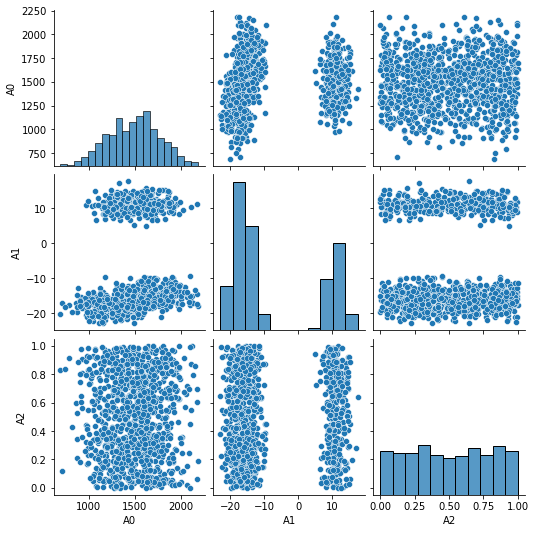

In [ ]:
sns.pairplot(X)

From the pairplot we observe that the column A1 has high correlation with both the columns A0 and A2. A0 is normally distributed, and A2 is uniformly distributed.

Note: The following solution is "overkill". The description of the problem is unclear on whether we need to _find_ the best clustering scheme (in which case we have to do Grid Search or something analogous to it, looping over the different models), or we have to choose one clustering scheme of our preference. 

For the latter solution, skip a few cells to find the elbow method.

Now, we prepare the data to perform a Grid Search and establish the best clustering scheme.

First, we define two functions that will be used to perform the Grid Search

In [3]:
# Grid Search for clustering based on silhouette score

def cv_silhouette_scorer(estimator, X):
    estimator.fit(X)
    try:
        cluster_labels = estimator.labels_
    except Exception as e:
      #  print(e,estimator)
        cluster_labels=estimator.predict(X)
    num_labels = len(set(cluster_labels))
    num_samples = len(X.index)
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return silhouette_score(X, cluster_labels)


def runGridSearch(estimator,params_dict,train_data):
    cv = [(slice(None), slice(None))]
    gs = GridSearchCV(estimator=estimator, param_grid=params_dict, scoring=cv_silhouette_scorer, cv=cv, n_jobs=-1)
    gs.fit(train_data)
    try:
        predicted_labels= gs.best_estimator_.labels_
    except:
        predicted_labels=gs.predict(train_data)
    
    return predicted_labels, gs.best_score_, gs.best_params_

In [4]:
model_lbls = [
              'km', 
              'ac', 
              'db',
]

k_range = list(range(2,11))

tuned_param_km = ParameterGrid({'n_clusters': k_range})
tuned_param_ac = ParameterGrid({'n_clusters': [range(2,11)], 'linkage': [['ward', 'average', 'complete', 'single']]})
tuned_param_db = ParameterGrid({'eps': [np.arange(0.1, 0.8, 0.05)], 'min_samples': [range(5, 11)]})

models = {
    'km': {'name': 'K Means',
           'estimator': KMeans(), 
           'param': tuned_param_km,
          },
    'ac': {'name': 'Agglomerative Clustering',
           'estimator': AgglomerativeClustering(),
           'param': tuned_param_ac
          },
    'db': {'name': 'DBSCAN',
           'estimator': DBSCAN(),
           'param': tuned_param_db,
          }
}

In [ ]:
best_model_lbl = ''
best_silhouette = 0.0
best_labels = []

for label in model_lbls:
  print('Trying estimator:', models[label]['name'])
  predicted_labels, silhouette, best_params = runGridSearch(models[label]['estimator'], models[label]['param'], X)
  n_clusters = len(set(predicted_labels))
  print('Estimator predicted', n_clusters, 'clusters, with a silhouette score of:', silhouette)
  print('Best parameters are:', best_params)
  if silhouette > best_silhouette:
    best_silhouette = silhouette
    best_model_lbl = label
    best_labels = predicted_labels

print('\n\nThe best model is', models[best_model_lbl]['name'], 'with a silhouette score of', round(best_silhouette, 4))

Trying estimator: K Means
Estimator predicted 2 clusters, with a silhouette score of: 0.5683030491080993
Best parameters are: {'n_clusters': 2}
Trying estimator: Agglomerative Clustering
Estimator predicted 2 clusters, with a silhouette score of: 0.5588746541828697
Best parameters are: {'linkage': 'ward', 'n_clusters': 2}
Trying estimator: DBSCAN
Estimator predicted 1 clusters, with a silhouette score of: -1.0
Best parameters are: {'eps': 0.1, 'min_samples': 5}


The best model is K Means with a silhouette score of 0.5683


The best clustering scheme for the dataset seems to be K means, with a silhouette score slightly higher than that of Agglomerative Clustering. DBSCAN produces really bad results on this dataset and is therefore to be excluded.

The best number of clusters predicted by both K Means and AC is 2, which is consistent with what is seen visually in the pairplot of the dataset. However, we observe that the real number of clusters is 3. This indicates that (as pointed by the problem description) a simple silhouette optimization is not enough to find the optimal number of cluster. ==> in any case it is wise to proceed with the elbow method for k-means.

### Alternative – Elbow Method for K-Means
(probably better): consider only K means and AC and plot the silhouette vs inertia, find the best compromise between the two for the optimal number of clusters. (Elbow method)

Elbow points: points in which the slope of inertia decreases. In this case 2 elbow points: k=3 and k=4. Silhouette increases with k=4 but we will choose k=3

In [46]:
# elbow method
scores = []

for params in tuned_param_km:
  model = KMeans(**params, random_state=random_state)
  labels = model.fit_predict(X)

  silhouette_scores = silhouette_score(X, labels)
  scores.append((model.inertia_, silhouette_scores))

print(scores)

[(25193142.48300268, 0.5683030491080993), (13079861.181527458, 0.5337106344943366), (7425539.959410018, 0.5405223516788928), (5276043.805918666, 0.5134087586418609), (3990953.6661921265, 0.49267203003371), (2865041.779838485, 0.5166430002105024), (2243136.072508702, 0.5128245674066461), (1892115.865625394, 0.5061785233541636), (1551831.1100341743, 0.49639597776556627)]


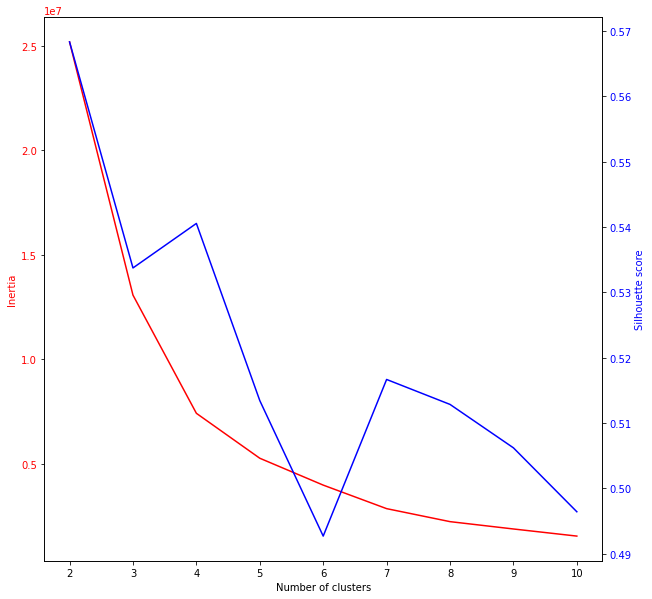

In [47]:
fig, ax1 = plt.subplots(figsize=(10,10))

ax1.set_xlabel('Number of clusters') 
ax1.set_ylabel('Inertia', color = 'red') 
ax1.plot(k_range, [x[0] for x in scores], color = 'red') 
ax1.tick_params(axis ='y', labelcolor = 'red') 
  
# Adding Twin Axes

ax2 = ax1.twinx() 
  
ax2.set_ylabel('Silhouette score', color = 'blue')
ax2.plot(k_range, [x[1] for x in scores], color = 'blue')
ax2.tick_params(axis ='y', labelcolor = 'blue')
#ax2.set_ylim([0.0,1.0])

plt.show()

In [48]:
k = 3
model = KMeans(n_clusters=k, random_state=random_state)
y_km = model.fit_predict(X)
print('Inertia:', model.inertia_, '; silhouette score:', round(silhouette_score(X, y_km), 4))

Inertia: 13079861.181527458 ; silhouette score: 0.5337


In [49]:
cm = pair_confusion_matrix(y, y_km)
cm_norm = np.empty([2, 2], dtype = float)
total = cm.sum()

for i in (0,1):
  for j in (0,1):
    cm_norm[i,j] = cm[i,j] / float(total)

In [50]:
print('Percentage of correct matches:', round((cm_norm[0,0]+cm_norm[1,1])*100, 1), '%')

Percentage of correct matches: 63.7 %


Possible pre-processing steps to increase accuracy: normalize the initial data. We repeat here the fitting after having normalized the dataset.

In [59]:
# Use MinMaxScaler to remap data in the range 0:1

scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(X)

#X_scaled = X.copy()
#X_scaled.loc(axis=1)[:] = scaled

X_scaled = pd.DataFrame(scaled, columns=X.columns)

X_scaled.head()

,A0,A1,A2
0,0.920959,0.187350,0.020071
1,0.420655,0.109367,0.521198
2,0.320742,0.083191,0.815046
3,0.490599,0.808861,0.848830
4,0.575483,0.856884,0.885065


In [61]:
# repeat the fitting (using the already found optimal hyperparameters)

model = KMeans(n_clusters=k, random_state=random_state)
y_km = model.fit_predict(X_scaled)
print('Inertia:', model.inertia_, '; silhouette score:', round(silhouette_score(X_scaled, y_km), 4))

Inertia: 80.4248227817803 ; silhouette score: 0.4279


In [62]:
cm = pair_confusion_matrix(y, y_km)
cm_norm = np.empty([2, 2], dtype = float)
total = cm.sum()

for i in (0,1):
  for j in (0,1):
    cm_norm[i,j] = cm[i,j] / float(total)

In [63]:
print('Percentage of correct matches:', round((cm_norm[0,0]+cm_norm[1,1])*100, 1), '%')

Percentage of correct matches: 77.8 %


We observe that the normalization of the dataset has a positive effect on the final accuracy of the model, increasing the number of correct matches by around 15%.